# 餐飲業逾期風險預測模型
由我國「應建立食品追溯追蹤系統之食品業者」規定可知，須申報食品流向資料於本署非追不可系統多為製造與輸入業者，對於販售與餐飲業者則無相關資料可用，無法推算其庫存，進而評估其是否可能存放逾期食品。因此，針對販售與餐飲業者，則透過後市場稽查資料及業者相關資訊，嘗試以監督式學習方法建構業者逾期食品違規風險預測模型，而此處為餐飲業資料的建模評估。

### 程式架構
* 資料前處理(Preprocessing.ipynb)
* 特徵篩選(FeatureSelection.ipynb)
* **資料不平衡處理(HandlingImbData.ipynb)**
* 模型配適(ModelFitting.ipynb)

## 資料不平衡處理

### Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTENC

### Data Import

In [2]:
dict_dfs_fs = pd.read_pickle('../data/data_fs.pkl')
print(dict_dfs_fs.keys())

dict_keys(['others', 'train', 'test', 'feature_selection'])


In [3]:
X_train = dict_dfs_fs['train']['X_select']
y_train = dict_dfs_fs['train']['y']

### Data Visualize

In [4]:
# 設定字型（以顯示中文）
plt.rcParams['font.family'] = 'Noto Sans TC'    # 思源黑體

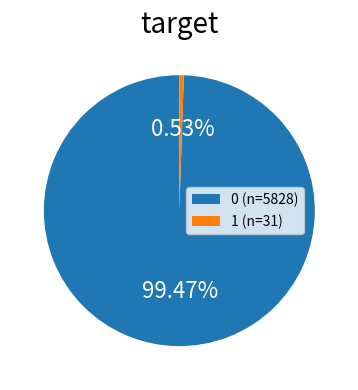

In [5]:
# 以 pie chart 呈現目標變數占比
def plot_pie(ser_cat): 
    # Step 1. prepare data
    df_count = ser_cat.value_counts()
    labels = df_count.index.astype('str').tolist()
    sizes = df_count.values
    total = sizes.sum()

    # Step 2. plot pie chart
    fig, ax = plt.subplots(figsize=(4, 4))
    wedges, texts, autotexts = ax.pie(
        x=sizes, 
        autopct=lambda pct: f'{pct: .2f}%', 
        textprops=dict(color='w', size=16), 
        startangle=90
    )

    # Step 3. add legend
    # legend_labels = [
    #     f'{l}: {t.get_text()}({s}/{total})' 
    #     for l, s, t in zip(labels, sizes, autotexts)
    # ]
    legend_labels = [f'{l} (n={s})' for l, s in zip(labels, sizes)]
    ax.legend(
        handles=wedges, labels=legend_labels, 
        bbox_to_anchor=(0.5, 0.5), 
        loc='center left'
    )

    # Step 4. layout
    ax.set_title(df_count.index.name, fontsize=20)
    fig.tight_layout()
    return fig, ax

plot_pie(y_train)
plt.show()

### Handling Imbalanced Dataset
以 SMOTENC 進行資...

* 合成樣本前若先將類別特徵做Dummy Encoding，可能出現多個子特徵同時為1之情況。

In [6]:
# 先將數值資料轉為 float ，合成樣本後再四捨五入，避免向零截斷（truncation toward zero）
cols_num = X_train.select_dtypes(include='uint32').columns.tolist()
X_sm0 = pd.concat([X_train[cols_num].astype('float32'), X_train.drop(cols_num, axis=1)], axis=1)

In [7]:
# 類別特徵名稱
cols_cat = X_sm0.drop(cols_num, axis=1).columns.tolist()

# 建立 SMOTENC 物件
sm = SMOTENC(
    categorical_features=cols_cat,    # specify categorical features
    sampling_strategy=3/7,    # ratio of minor/major
    random_state=12
)

# 合成樣本（加在原始資料後）
X_sm, y_sm = sm.fit_resample(X=X_sm0, y=y_train)
X_sm = X_sm.round(0)    # 四捨五入數值資料

In [8]:
del cols_num, cols_cat, X_sm0, sm

In [12]:
dict_dfs_fs['train']['X_smote'] = X_sm
dict_dfs_fs['train']['y_smote'] = y_sm
pd.to_pickle(dict_dfs_fs, '../data/data_sm.pkl')